# Load libraries

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import math
import os

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

random_seed = 1989
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == "cuda":
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif device == "mps":
    torch.mps.manual_seed(random_seed)
    torch.backends.mps.deterministic = True
    torch.backends.mps.benchmark = False

# Load the data

In [2]:
# Read in the data
train_label = pd.read_csv("../../data/train_label_coordinates_preprocessed.csv")
labels = train_label["condition"]
# Convert labels to integers
label_map = {
    "Spinal Canal Stenosis": 0,
    "Right Neural Foraminal Narrowing": 1,
    "Left Neural Foraminal Narrowing": 2,
    "Right Subarticular Stenosis": 3,
    "Left Subarticular Stenosis": 4
}
labels = labels.map(label_map)

path_to_image = train_label["preprocessed_file_path"]

# Create data loader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, path_to_image, labels, transform=None):
        self.path_to_image = path_to_image
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.path_to_image)

    def __getitem__(self, idx):
        path_starter = "../../data/"
        image = Image.open(path_starter + self.path_to_image[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # convert from grayscale to RGB
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageDataset(path_to_image, labels, transform)

In [12]:
batch_size = 64

# Split the data into training, validation, and test sets
# with a balance of the labels. 70-10-20 split
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(range(len(labels)), test_size=0.2, stratify=labels)
train_idx, val_idx = train_test_split(train_idx, test_size=0.125, stratify=labels[train_idx])

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

# Define the model

In [13]:
# Define the model
model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(4096, 5)
model = model.to(device)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 128,786,821 trainable parameters


In [15]:
# Define the loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set up model training and evaluation

In [16]:
from sklearn import metrics as sklearn_metrics

def train(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, "Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = loss_fn(outputs, labels)
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)

    return epoch_loss

def get_metrics(labels, predictions, probs):
    metrics = {
        "Accuracy": sklearn_metrics.accuracy_score(labels, predictions),
        "Top-5 Accuracy": sklearn_metrics.top_k_accuracy_score(labels, probs, k=5),
        "Macro Recall": sklearn_metrics.recall_score(labels, predictions, average='macro'),
        "Weighted Recall": sklearn_metrics.recall_score(labels, predictions, average='weighted'),
        "Macro F1": sklearn_metrics.f1_score(labels, predictions, average='macro'),
        "Weighted F1": sklearn_metrics.f1_score(labels, predictions, average='weighted'),
        "Weighted AUC Score": sklearn_metrics.roc_auc_score(labels, probs, average='weighted', multi_class='ovr'),
    }
    return metrics


def evaluate(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, "Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = loss_fn(outputs, labels)
            
            running_loss += batch_loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predictions == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)

    metrics = get_metrics(all_labels, all_predictions, all_probs)
    accuracy = correct_predictions / total_predictions * 100

    return epoch_loss, accuracy, metrics

# Prepare early stopping

In [17]:
class EarlyStopping():
    def __init__(self, patience = 2, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = None
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            if self.best_loss is not None:
                print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
            else:
                print(f'Saving model with validation loss: {val_loss:.6f}')

        self.best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

# Find best learning rate

In [18]:
def save_model(m, p):
  torch.save(m.state_dict(), p)
def load_model(m, p):
  m.load_state_dict(torch.load(p))
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [19]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=1, beta=0.9):
  losses = []
  # Model save path
  p = "mode_tmp.pth"
  save_model(model, str(p))
  num = len(train_dl)-1
  mult = (lr_high / lr_low) ** (1.0/num)
  lr = lr_low
  avg_loss = 0.
  best_loss = 0.
  batch_num = 0
  log_lrs = []
  lrs = []

  model.train()
  for i in range(epochs):
    for x,y in train_dl:
      batch_num +=1
      optim = get_optimizer(model, lr=lr)
      x = x.to(device)
      y = y.to(device) 
      out = model(x)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(out, y)

      #Compute the smoothed loss
      avg_loss = beta * avg_loss + (1-beta) *loss.item()
      smoothed_loss = avg_loss / (1 - beta**batch_num)

      #Stop if the loss is exploding
      if batch_num > 1 and smoothed_loss > 4 * best_loss:
        return log_lrs, losses

      #Record the best loss
      if smoothed_loss < best_loss or batch_num==1:
        best_loss = smoothed_loss
      #Store the values
      losses.append(smoothed_loss)
      log_lrs.append(math.log10(lr))
      lrs.append(lr)

      optim.zero_grad()
      loss.backward()
      optim.step()
      #Update the lr for the next step
      lr *= mult
  load_model(model, str(p))

  return log_lrs, losses, lrs

In [11]:
out = LR_range_finder(model, train_loader, lr_low=1e-5, lr_high=1, epochs=1, beta=0.9)

KeyboardInterrupt: 

In [ ]:
# get number of items in tuple out
losses = out[1]
log_lrs = out[0]

# Get top 5 best losses, and corresponding learning rates
# convert log learning rates to learning rates
lrs = [10 ** x for x in log_lrs]
# get top 5 best losses
top_5_losses = sorted(losses)[:5]
# get corresponding learning rates
top_5_lrs = [lrs[losses.index(l)] for l in top_5_losses]

for i in range(5):
    print(f"Loss: {top_5_losses[i]}, Learning Rate: {top_5_lrs[i]}")

Loss: 0.23147647539436428, Learning Rate: 3.6989215232506555e-05
Loss: 0.23916500486340228, Learning Rate: 3.678982309608297e-05
Loss: 0.2427061926149562, Learning Rate: 3.659150579252121e-05
Loss: 0.260121171377312, Learning Rate: 2.645667188628279e-05
Loss: 0.26065853523158705, Learning Rate: 3.639425752788332e-05


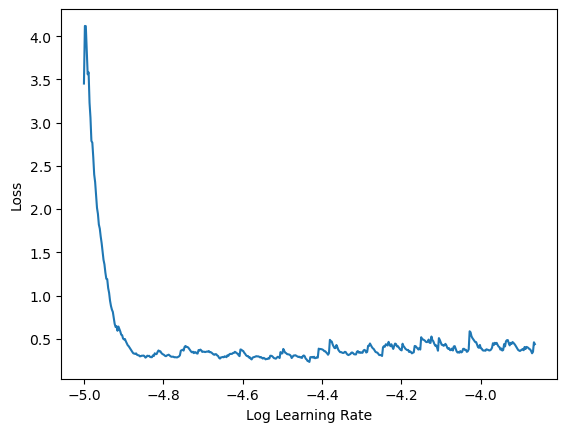

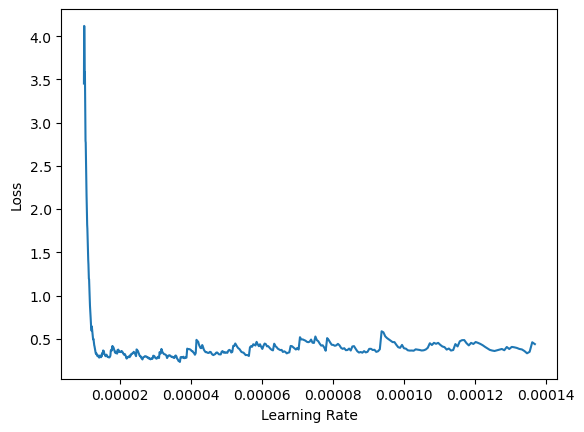

In [ ]:
# Plot the learning rate range test
plt.plot(log_lrs, losses)
plt.xlabel("Log Learning Rate")
plt.ylabel("Loss")
plt.show()

# Plot the learning rate range test
plt.plot(lrs, losses)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

# Define model and train

In [20]:
# Define the model
model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5)
model = model.to(device)

In [21]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [22]:
num_epochs = 10
patience = 2
early_stopping = EarlyStopping(patience = patience, verbose = True)

train_losses = []
val_losses = []
val_accuracies = []
metrics_list = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, loss, optimizer, device)
    val_loss, val_accuracy, metrics = evaluate(model, val_loader, loss, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    metrics_list.append(metrics)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print('Early stopping')
        break

Training:   1%|          | 4/533 [00:04<09:14,  1.05s/it]

In [ ]:
# evaluate on test set
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_accuracy, test_metrics = evaluate(model, test_loader, loss, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
print(test_metrics)

In [ ]:
# Plot the training and validation losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('alexnet_train_val_loss.png')
plt.show()

# Plot the validation accuracy
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('alexnet_val_accuracy.png')
plt.show()